# Week 1 — Vision & Foundation: Baseline Regression (Agricultural Yield)
DataVerse Africa Internship Cohort 3.0 — Data Science Track

**What you’ll do**: Frame an ML problem, explore data, build a leak-free preprocessing pipeline, and train a baseline regression model. 

**Deliverable**: A baseline model + short research brief. 



## Learning Outcomes
- Explain supervised vs. unsupervised learning and where regression fits.
- Run an end‑to‑end *tabular* ML workflow with scikit‑learn.
- Perform basic EDA (shape, missingness, distributions, correlations).
- Build a **ColumnTransformer + Pipeline** with `SimpleImputer`, `StandardScaler`, and `OneHotEncoder`.
- Train/evaluate baseline regressors (Linear Regression, Random Forest) using **MAE/RMSE/R²**.
- Avoid **data leakage** using pipelines and proper splits.

> **Tip**: This notebook uses a **synthetic Nigeria‑like crop yield dataset** to make the lab self‑contained. In project weeks, swap in FAOSTAT/field data.



## 0) Setup
Installed libraries assumed: `numpy`, `pandas`, `matplotlib`, `scikit-learn`, `joblib` (optional).

> If you get import errors, install locally (e.g., `pip install pandas scikit-learn matplotlib joblib`).


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib, os, pathlib


## 1) Load data
We'll start with a small, tabular dataset: synthetic crop yields (tons/ha) with climate and management features.


In [31]:

DATA_PATH = r"../data/week1_synthetic_agri_yield.csv"
df = pd.read_csv(DATA_PATH)
df.head()


,year,region,seed_variety,rainfall_mm,temperature_c,fertilizer_kg_ha,soil_ph,soil_organic_matter_pct,field_size_ha,pests_index,irrigated,yield_t_ha
0,2016,North East,Improved A,1046.8,24.84,61.0,5.84,2.16,1.98,3.17,0,4.34
1,2013,South East,Local,1103.1,27.18,30.7,6.47,1.99,1.01,1.86,0,4.26
2,2022,North East,Local,1271.5,29.34,127.8,5.92,1.59,1.95,1.33,0,3.75
3,2020,North East,Improved A,1283.6,26.79,95.1,5.78,2.41,3.38,3.17,0,4.47
4,2017,North West,Local,1364.6,23.61,97.5,5.51,2.11,1.15,4.58,1,3.85


In [32]:
df.head(10)

,year,region,seed_variety,rainfall_mm,temperature_c,fertilizer_kg_ha,soil_ph,soil_organic_matter_pct,field_size_ha,pests_index,irrigated,yield_t_ha
0,2016,North East,Improved A,1046.8,24.84,61.0,5.84,2.16,1.98,3.17,0,4.34
1,2013,South East,Local,1103.1,27.18,30.7,6.47,1.99,1.01,1.86,0,4.26
2,2022,North East,Local,1271.5,29.34,127.8,5.92,1.59,1.95,1.33,0,3.75
3,2020,North East,Improved A,1283.6,26.79,95.1,5.78,2.41,3.38,3.17,0,4.47
4,2017,North West,Local,1364.6,23.61,97.5,5.51,2.11,1.15,4.58,1,3.85
5,2022,North East,Improved A,1702.6,26.89,NaN,5.15,2.01,5.81,0.74,1,4.62
6,2014,North Central,Improved B,1155.8,28.39,53.5,5.97,1.51,1.20,2.15,0,4.20
7,2016,South South,Improved A,1000.4,24.78,58.0,6.29,NaN,1.68,1.39,0,5.03
8,2019,South South,Improved B,855.2,25.73,77.8,6.14,2.33,1.10,2.02,0,4.58
9,2012,South East,Local,1017.3,26.03,112.6,NaN,1.72,1.89,1.54,1,4.58



## 2) Quick EDA (keep it *question‑driven*)
**Guiding questions**  
1. What is the target distribution? (Range/plausibility)  
2. Which features are numerical vs categorical? Any missingness?  
3. Do simple bivariate plots hint at relationships worth modeling?  

> We'll restrict to a few plots to keep Week‑1 time‑boxed. Avoid overfitting your story to EDA! 


In [33]:
# checking for missing values in the data 
df.isnull().sum()

year                        0
region                      0
seed_variety                0
rainfall_mm                23
temperature_c               0
fertilizer_kg_ha           19
soil_ph                    24
soil_organic_matter_pct    26
field_size_ha               0
pests_index                 0
irrigated                   0
yield_t_ha                  0
dtype: int64

In [34]:
# checking for duplicates in the data 
df.duplicated().sum()

0

In [35]:
# checking for the shape of the dsataset
df.shape

(600, 12)

In [36]:
# checking the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     600 non-null    int64  
 1   region                   600 non-null    object 
 2   seed_variety             600 non-null    object 
 3   rainfall_mm              577 non-null    float64
 4   temperature_c            600 non-null    float64
 5   fertilizer_kg_ha         581 non-null    float64
 6   soil_ph                  576 non-null    float64
 7   soil_organic_matter_pct  574 non-null    float64
 8   field_size_ha            600 non-null    float64
 9   pests_index              600 non-null    float64
 10  irrigated                600 non-null    int64  
 11  yield_t_ha               600 non-null    float64
dtypes: float64(8), int64(2), object(2)
memory usage: 56.4+ KB


In [37]:
# checking for unique values in region
df['region'].unique()

array(['North East', 'South East', 'North West', 'North Central',
       'South South', 'South West'], dtype=object)

In [38]:
# counting unique values in region
df['region'].nunique()

6

In [39]:
# checking for the most occuring region
df['region'].value_counts()

region
South South      111
North Central    105
North East       100
North West        97
South East        94
South West        93
Name: count, dtype: int64

In [40]:
# checking for the most occuring region
df['seed_variety'].value_counts()

seed_variety
Local         205
Improved B    201
Improved A    194
Name: count, dtype: int64

In [41]:
#  getting the data summary
display(df.describe(include='all'))

,year,region,seed_variety,rainfall_mm,temperature_c,fertilizer_kg_ha,soil_ph,soil_organic_matter_pct,field_size_ha,pests_index,irrigated,yield_t_ha
count,600.000000,600,600,577.000000,600.000000,581.000000,576.000000,574.000000,600.000000,600.000000,600.000000,600.000000
unique,NaN,6,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,South South,Local,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,111,205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2016.498333,NaN,NaN,1228.380243,26.059667,59.320998,6.225538,1.944495,1.921083,2.971450,0.233333,4.351217
std,4.096906,NaN,NaN,246.305897,1.979767,42.498999,0.632365,0.495522,1.162841,1.647869,0.423305,0.492469
min,2010.000000,NaN,NaN,475.900000,19.960000,0.800000,4.500000,0.500000,0.250000,0.100000,0.000000,2.620000
25%,2013.000000,NaN,NaN,1056.600000,24.775000,29.700000,5.757500,1.622500,1.100000,1.637500,0.000000,4.020000
50%,2016.000000,NaN,NaN,1231.400000,25.985000,50.600000,6.235000,1.960000,1.670000,2.770000,0.000000,4.380000
75%,2020.000000,NaN,NaN,1385.500000,27.390000,77.900000,6.652500,2.260000,2.460000,4.200000,0.000000,4.720000


Text(0.5, 1.0, 'Yield (t/ha)')

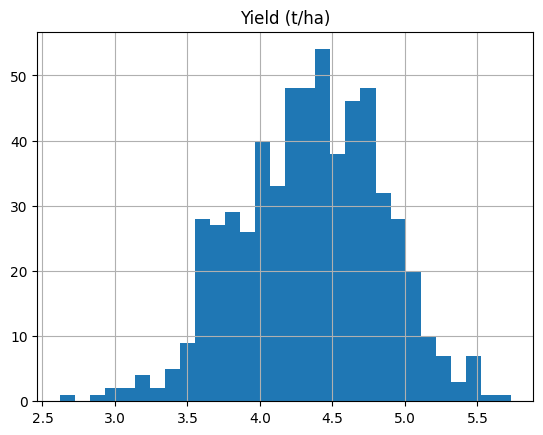

In [42]:
# Hist of target
plt.figure()
df['yield_t_ha'].hist(bins=30)
plt.title('Yield (t/ha)')

Text(0.5, 1.0, 'Rainfall vs Yield')

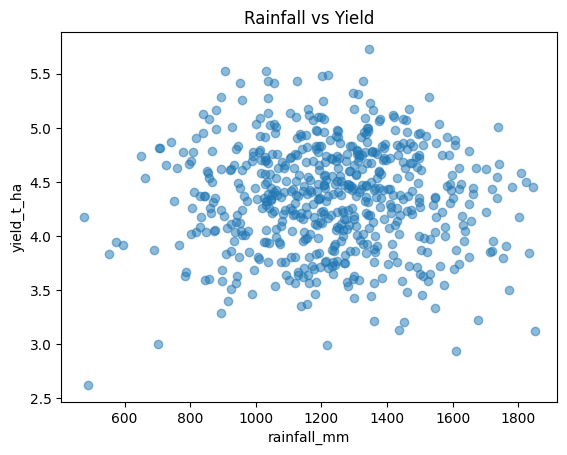

In [43]:
# Scatter: rainfall vs yield
plt.figure()
plt.scatter(df['rainfall_mm'], df['yield_t_ha'], alpha=0.5)
plt.xlabel('rainfall_mm'); plt.ylabel('yield_t_ha'); plt.title('Rainfall vs Yield')

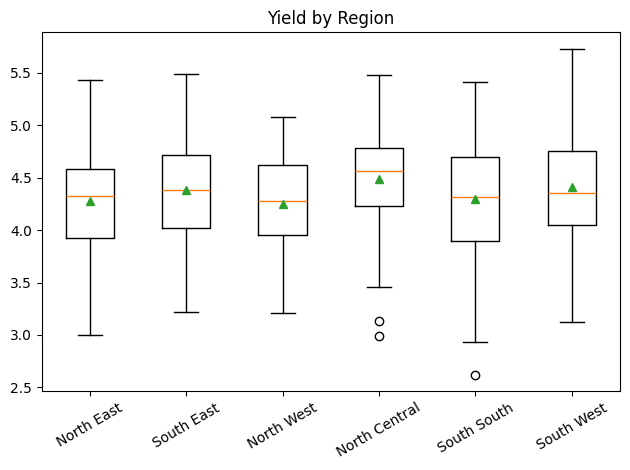

In [44]:
# Boxplot: region vs yield
plt.figure()
# simple matplotlib boxplot expects sequences
grouped = [df.loc[df['region']==r, 'yield_t_ha'].dropna() for r in df['region'].dropna().unique()]
plt.boxplot(grouped, labels=df['region'].dropna().unique(), vert=True, showmeans=True)
plt.xticks(rotation=30)
plt.title('Yield by Region')
plt.tight_layout()


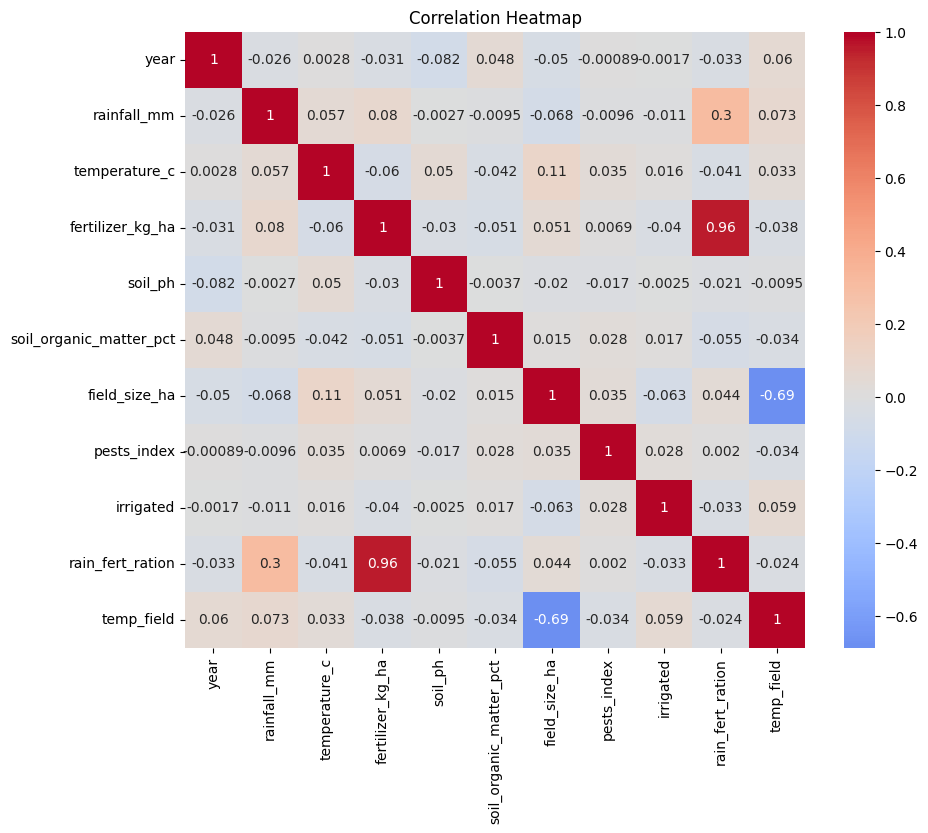

In [62]:
# plotting the correlation matrix
import seaborn as sns
correlation_matrix = df[['year', 'rainfall_mm', 'temperature_c', 'fertilizer_kg_ha', 'soil_ph', 'soil_organic_matter_pct', 'field_size_ha', 'pests_index', 'irrigated', 'rain_fert_ration', 'temp_field']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()


## 3) Train/test split and preprocessing (leak‑safe)
- Split **before** any data‑dependent transforms.
- Use `ColumnTransformer` to combine numeric and categorical pipelines.


In [45]:
# data columns
df.columns

Index(['year', 'region', 'seed_variety', 'rainfall_mm', 'temperature_c',
       'fertilizer_kg_ha', 'soil_ph', 'soil_organic_matter_pct',
       'field_size_ha', 'pests_index', 'irrigated', 'yield_t_ha'],
      dtype='object')

## Feature Engineering

The idea is that we have some existing features and we are creating new features out ot fhem.

In most cases, we engineer new features based on our domain knowledge about the problem and the data we are handling.

In [46]:
df.head(10)

,year,region,seed_variety,rainfall_mm,temperature_c,fertilizer_kg_ha,soil_ph,soil_organic_matter_pct,field_size_ha,pests_index,irrigated,yield_t_ha
0,2016,North East,Improved A,1046.8,24.84,61.0,5.84,2.16,1.98,3.17,0,4.34
1,2013,South East,Local,1103.1,27.18,30.7,6.47,1.99,1.01,1.86,0,4.26
2,2022,North East,Local,1271.5,29.34,127.8,5.92,1.59,1.95,1.33,0,3.75
3,2020,North East,Improved A,1283.6,26.79,95.1,5.78,2.41,3.38,3.17,0,4.47
4,2017,North West,Local,1364.6,23.61,97.5,5.51,2.11,1.15,4.58,1,3.85
5,2022,North East,Improved A,1702.6,26.89,NaN,5.15,2.01,5.81,0.74,1,4.62
6,2014,North Central,Improved B,1155.8,28.39,53.5,5.97,1.51,1.20,2.15,0,4.20
7,2016,South South,Improved A,1000.4,24.78,58.0,6.29,NaN,1.68,1.39,0,5.03
8,2019,South South,Improved B,855.2,25.73,77.8,6.14,2.33,1.10,2.02,0,4.58
9,2012,South East,Local,1017.3,26.03,112.6,NaN,1.72,1.89,1.54,1,4.58


In [47]:
# Engineering new features
#  multiplyingrainfall and fertilizer
df['rain_fert_ration'] = df['rainfall_mm'] * df['fertilizer_kg_ha']
#  dividing temperature by field size
df['temp_field'] = df['temperature_c'] / df['field_size_ha']

In [48]:
# target variable
target = 'yield_t_ha'

# other features
features = [c for c in df.columns if c != target]
print(features)

['year', 'region', 'seed_variety', 'rainfall_mm', 'temperature_c', 'fertilizer_kg_ha', 'soil_ph', 'soil_organic_matter_pct', 'field_size_ha', 'pests_index', 'irrigated', 'rain_fert_ration', 'temp_field']


In [49]:
# # dropping rows with missing values
# df = df.dropna()
# print(f"Shape of df after dropping missing values: {df.shape}")

In [50]:
# keeping different dataframes for features and target
X = df[features]
y = df[target]

In [51]:
X.head()

,year,region,seed_variety,rainfall_mm,temperature_c,fertilizer_kg_ha,soil_ph,soil_organic_matter_pct,field_size_ha,pests_index,irrigated,rain_fert_ration,temp_field
0,2016,North East,Improved A,1046.8,24.84,61.0,5.84,2.16,1.98,3.17,0,63854.80,12.545455
1,2013,South East,Local,1103.1,27.18,30.7,6.47,1.99,1.01,1.86,0,33865.17,26.910891
2,2022,North East,Local,1271.5,29.34,127.8,5.92,1.59,1.95,1.33,0,162497.70,15.046154
3,2020,North East,Improved A,1283.6,26.79,95.1,5.78,2.41,3.38,3.17,0,122070.36,7.926036
4,2017,North West,Local,1364.6,23.61,97.5,5.51,2.11,1.15,4.58,1,133048.50,20.530435


In [52]:
y.head()


0    4.34
1    4.26
2    3.75
3    4.47
4    3.85
Name: yield_t_ha, dtype: float64

In [53]:
# splitting our data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2
)

In [54]:
# seperating numerical features from categorical features
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
print(f"numeric_features: {numeric_features}")
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print(f"categorical_features: {categorical_features}")

numeric_features: ['year', 'rainfall_mm', 'temperature_c', 'fertilizer_kg_ha', 'soil_ph', 'soil_organic_matter_pct', 'field_size_ha', 'pests_index', 'irrigated', 'rain_fert_ration', 'temp_field']
categorical_features: ['region', 'seed_variety']


In [55]:
# creating pipelines for numerical and categorical features
numeric_pipe = Pipeline([
    # treating missing values
    ('imputer', SimpleImputer(strategy='median')),
    # scaling numerical features
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline([
    # treating missing values
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # encoding categorical features
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', categorical_pipe, categorical_features)
])


## 4) Baseline models
Start simple: Linear Regression and Random Forest. Use identical preprocessing.


In [56]:

def evaluate(model, X_train, y_train, X_test, y_test, name='model'):
    # model training
    model.fit(X_train, y_train)
    # model prediction
    preds = model.predict(X_test)
    # model evaluation
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R^2={r2:.3f}")
    return {'model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}


# Linear regression model
linreg = Pipeline([('prep', preprocess), ('model', LinearRegression())])
# Random forest model
rf = Pipeline([('prep', preprocess), ('model', RandomForestRegressor(random_state=42, n_estimators=300))])

scores = []
scores.append(evaluate(linreg, X_train, y_train, X_test, y_test, 'LinearRegression'))
scores.append(evaluate(rf, X_train, y_train, X_test, y_test, 'RandomForestRegressor'))

pd.DataFrame(scores)


LinearRegression: MAE=0.270, RMSE=0.337, R^2=0.499


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RandomForestRegressor: MAE=0.253, RMSE=0.328, R^2=0.527


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,model,MAE,RMSE,R2
0,LinearRegression,0.269926,0.337420,0.499058
1,RandomForestRegressor,0.252689,0.327726,0.527430



### Notes & next steps
- **Pick the metric** that matches your business objective (MAE often reads in the same units as the target).  
- For Week‑2 we'll add **cross‑validation** and **hyperparameter tuning**; for now record a **baseline**.
- Save the best baseline for reproducibility.


In [57]:

best = max(scores, key=lambda d: d['R2'])
best_name = best['model']
best_pipe = rf if best_name == 'RandomForestRegressor' else linreg
out_path = pathlib.Path('best_baseline_model.joblib')
joblib.dump(best_pipe, out_path)
print('Saved:', out_path.resolve())


Saved: /Users/apple/Downloads/DataVerse/Week 1/scripts/best_baseline_model.joblib



## Appendix: Optional classification demo (for Tuesday live-coding)
This short example demonstrates binary classification using Logistic Regression with scikit‑learn.


In [58]:

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

data = load_breast_cancer(as_frame=True)
Xc = data['data']; yc = data['target']

clf = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=200)
)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=42)
clf.fit(Xc_train, yc_train)
print('Classification R^2 doesn\'t apply; use accuracy:')
print('Accuracy:', (clf.score(Xc_test, yc_test)))


Classification R^2 doesn't apply; use accuracy:
Accuracy: 0.9736842105263158
